<a href="https://colab.research.google.com/github/Parv-Agarwal/Internship-project/blob/main/Triplet_Loss_%2B_GRL_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import os
import numpy as np
from PIL import Image


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 64
nz = 100  # Size of z latent vector (i.e., the generator input noise)
ngf = 64  # Size of feature maps in generator
nc = 3    # Number of channels in the generated images (3 for RGB)
num_epochs = 5
lr = 0.0002
num_classes = 10
lambda_grl = 1.0  # Lambda for the GRL layer
alpha = 0.001

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z + one-hot class vector
            nn.ConvTranspose2d(nz + 10, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output size: (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 48, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.conv_to_single_channel = nn.Conv2d(48, 1, kernel_size=1)  # Reduce channels to 1
        self.adaptive_pool = nn.AdaptiveAvgPool2d((28, 28))

    def forward(self, x):
        x = self.conv(x)                        # Shape: (batch_size, 48, H, W)
        x = self.conv_to_single_channel(x)      # Shape: (batch_size, 1, H, W)
        x = self.adaptive_pool(x)               # Shape: (batch_size, 1, 28, 28)
        x = x.view(x.size(0), -1)               # Flatten -> Shape: (batch_size, 28 * 28)
        return x


In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
# Gradient Reversal Layer
from torch.autograd import Function
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradientReversalFunction.apply(x, lambda_)

In [ ]:
netG = Generator(nz, ngf, nc).to(device)
feature_extractor = FeatureExtractor().to(device)
classifier = Classifier().to(device)
netG.load_state_dict(torch.load('pre_trained_gan_weights_mnist.pth'))
feature_extractor.load_state_dict(torch.load('pre_trained_feature_extractor_weights.pth'))
classifier.load_state_dict(torch.load('pre_trained_classifier_weights.pth'))

for param in feature_extractor.parameters():
    param.requires_grad = False

for param in classifier.parameters():
    param.requires_grad = False


<ipython-input-8-7e9d0162264e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load('pre_trained_gan_weights_mnist.pth'))
<ipython-input-8-7e9d01

In [ ]:
netG.train()
feature_extractor.eval()  # Feature extractor is pre-trained and fixed\
classifier.eval()

Classifier(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
)

In [ ]:
import matplotlib.pyplot as plt
def test_label(netG, class_label):
  netG.eval()

  # Define the label for which you want to generate MNIST-M images (e.g., 5)
  test_label = class_label
  num_samples = 10  # Number of images to generate

  # Generate random noise
  noise = torch.randn(num_samples, nz, 1, 1, device=device)

  # Create one-hot encoding of the test label
  test_label_tensor = torch.tensor([test_label] * num_samples, device=device)
  test_label_one_hot = torch.nn.functional.one_hot(test_label_tensor, num_classes).type(torch.float).to(device)
  test_label_one_hot_gen = test_label_one_hot.unsqueeze(2).unsqueeze(3)

  # Concatenate the noise and the label
  noise_with_labels = torch.cat((noise, test_label_one_hot_gen), 1)

  # Generate fake MNIST-M images
  with torch.no_grad():  # No need to track gradients during inference
      fake_images = netG(noise_with_labels).cpu()

  # Display generated images
  fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
  for i in range(num_samples):
      # Assuming MNIST-M images are RGB, we use transpose to convert the generated tensor to (H, W, C)
      axes[i].imshow(fake_images[i].permute(1, 2, 0))  # permute to (height, width, channels) for RGB
      axes[i].axis('off')

  plt.show()

In [ ]:
# Prepare the MNIST dataset with the specified transform
transform_mnist = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(num_output_channels=3),  # Converts grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for 3 channels
])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)

In [ ]:
# Split the dataset into positive (labels != 5) and negative (label 5)
positive_indices = [i for i, target in enumerate(mnist_dataset.targets) if target != 5]
negative_indices = [i for i, target in enumerate(mnist_dataset.targets) if target == 5]

positive_dataset = Subset(mnist_dataset, positive_indices)
negative_dataset = Subset(mnist_dataset, negative_indices)

positive_loader = DataLoader(positive_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
negative_loader = DataLoader(negative_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [ ]:
# Optimizer for the Generator
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# Triplet loss function
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)
classification_loss_fn = nn.NLLLoss()

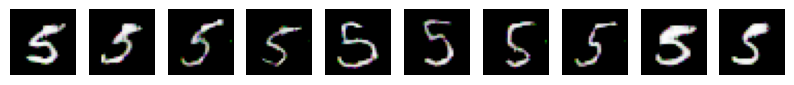

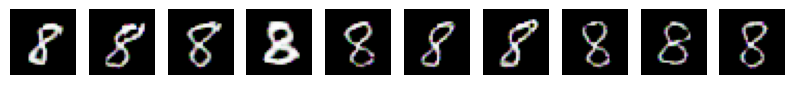

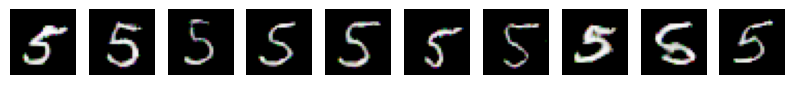

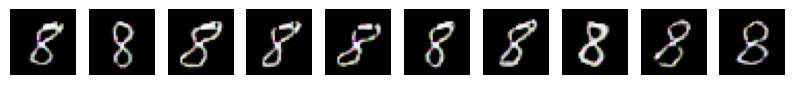

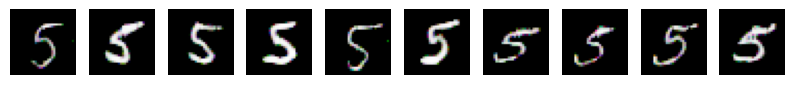

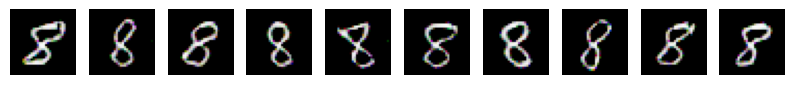

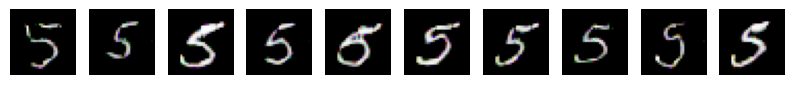

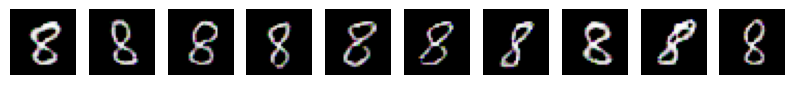

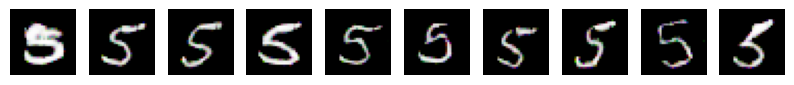

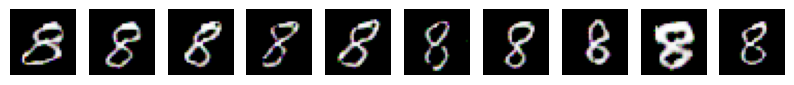

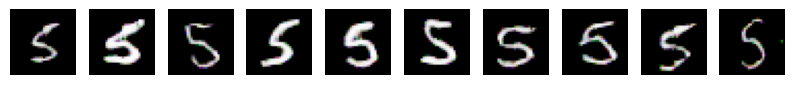

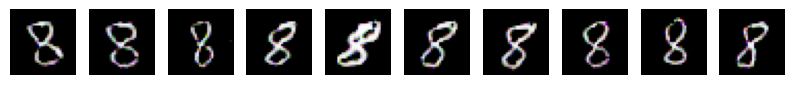

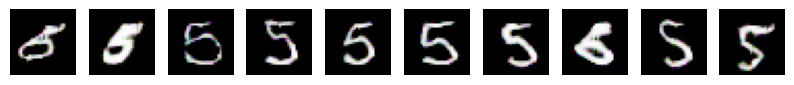

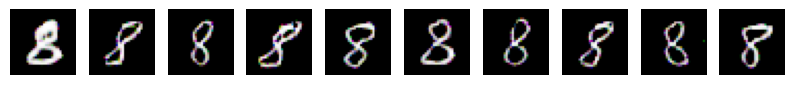

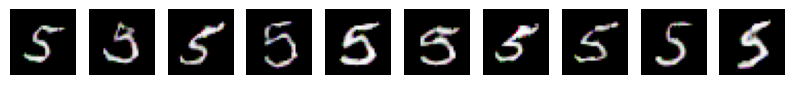

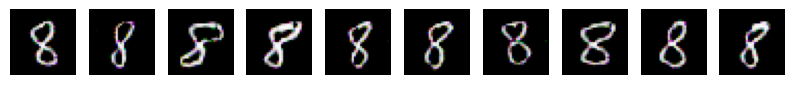

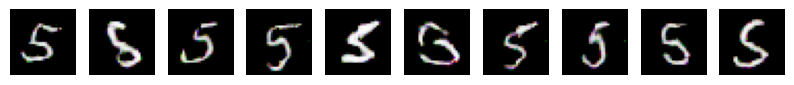

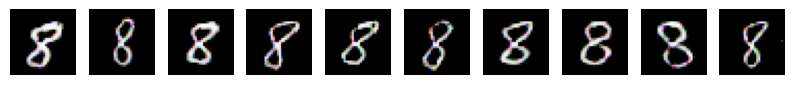

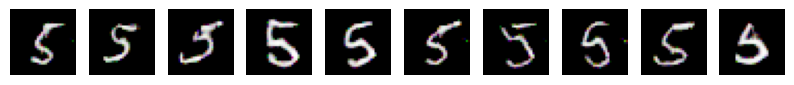

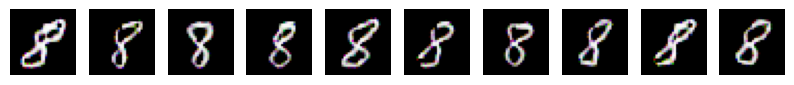

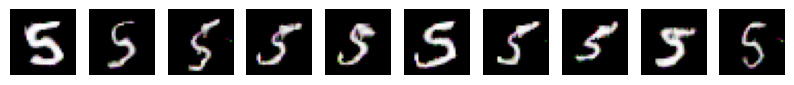

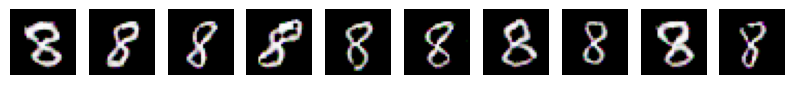

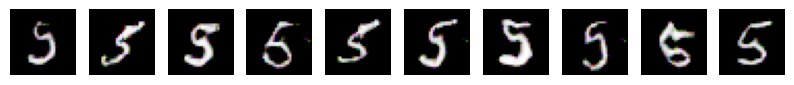

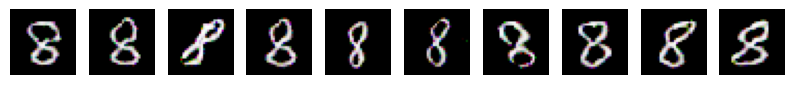

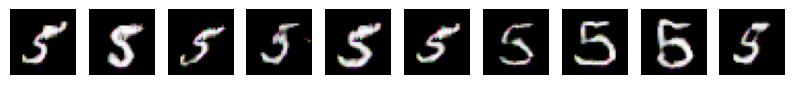

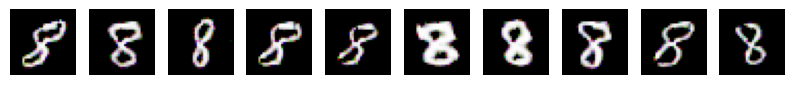

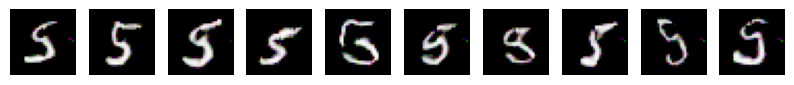

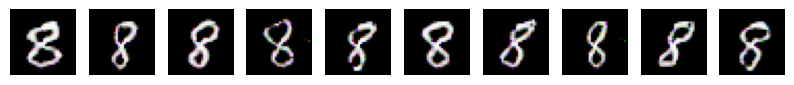

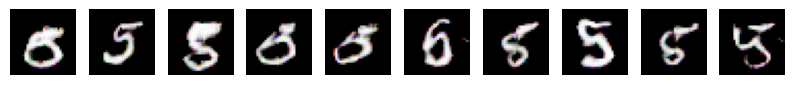

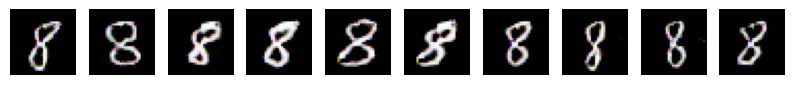

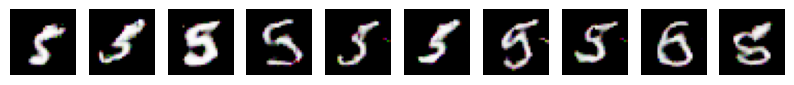

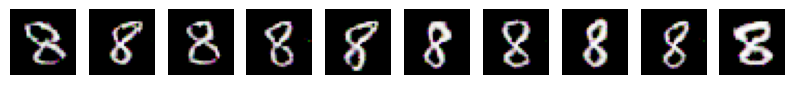

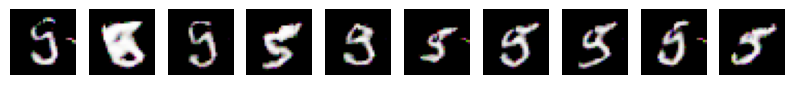

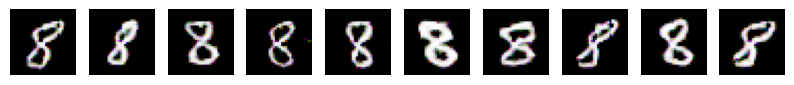

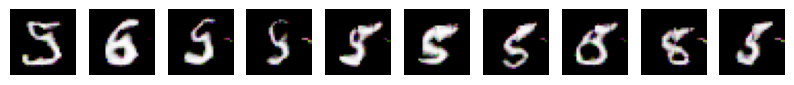

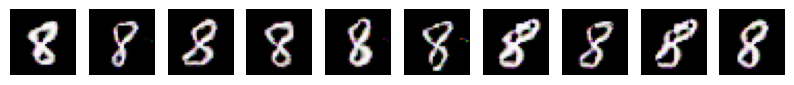

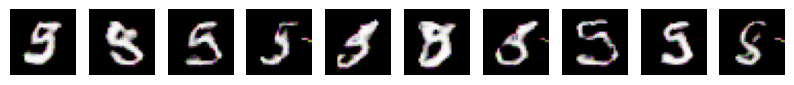

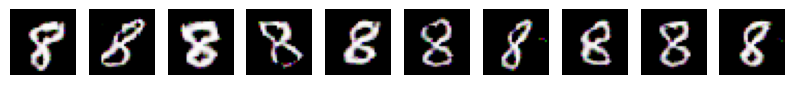

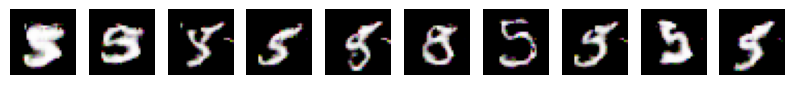

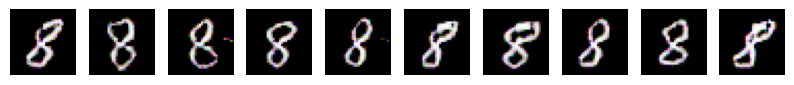

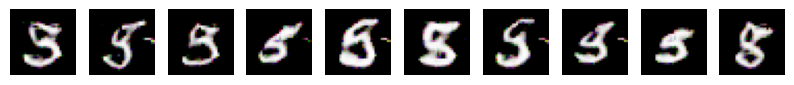

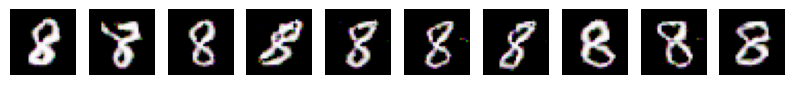

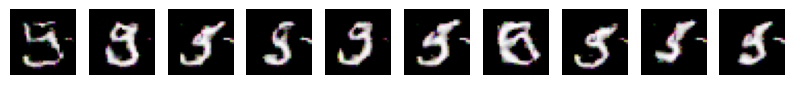

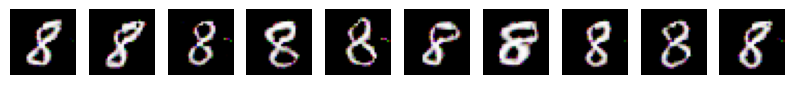

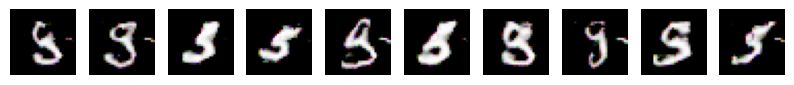

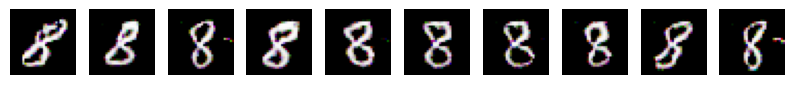

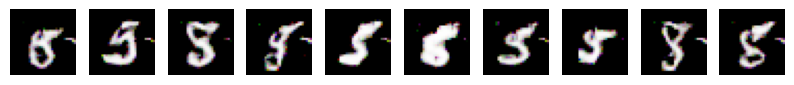

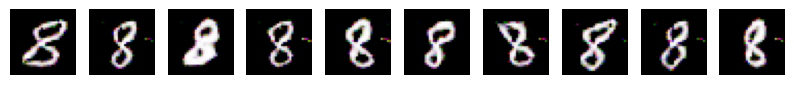

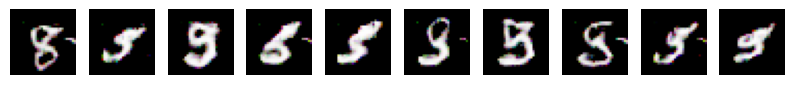

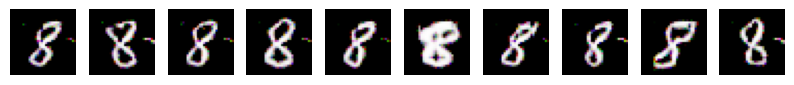

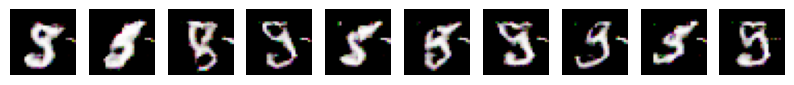

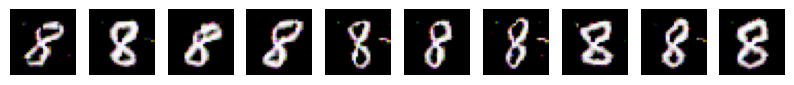

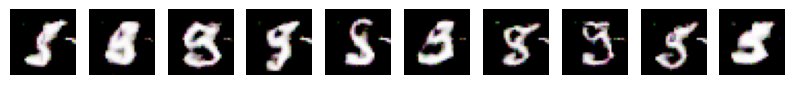

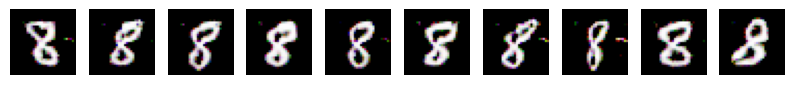

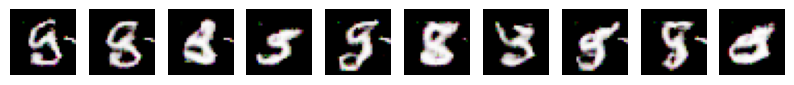

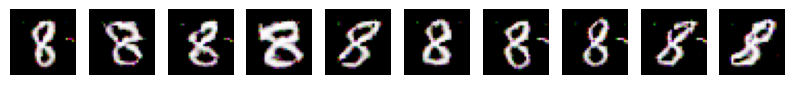

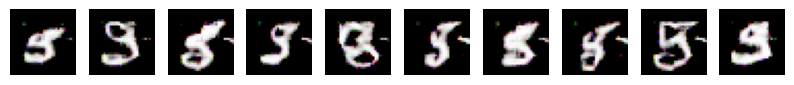

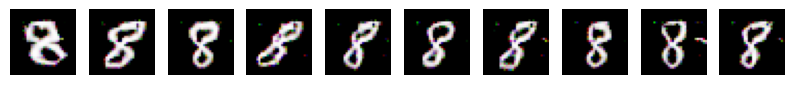

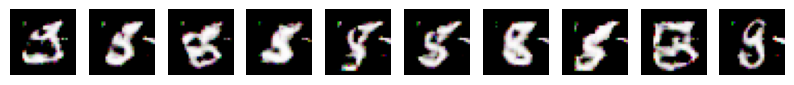

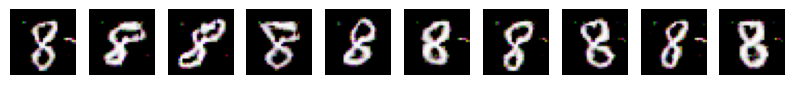

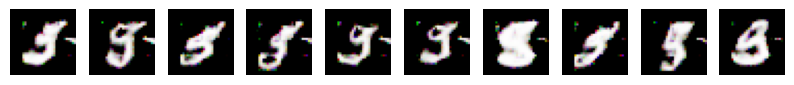

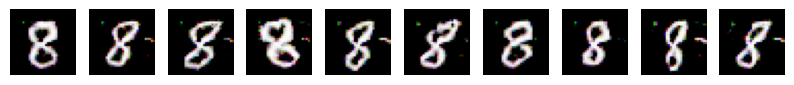

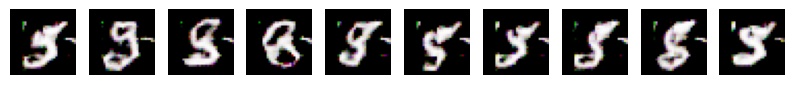

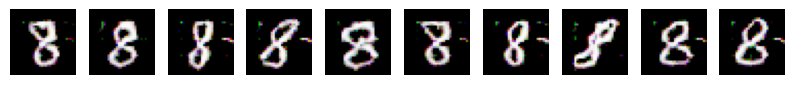

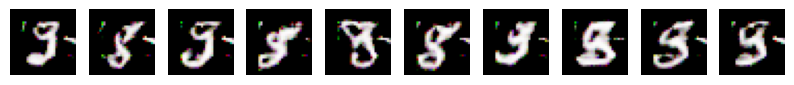

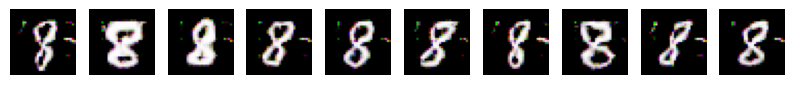

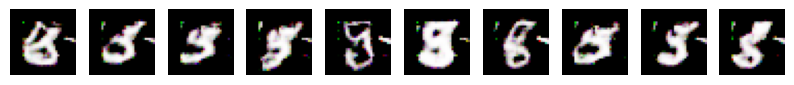

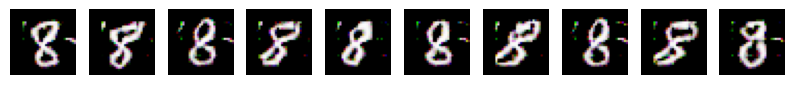

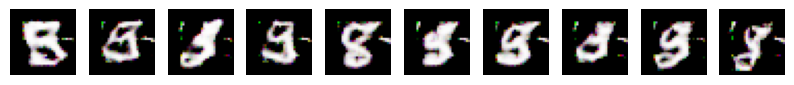

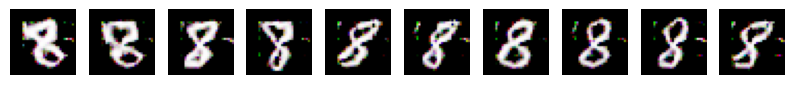

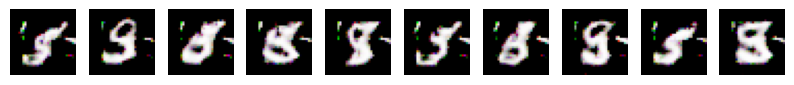

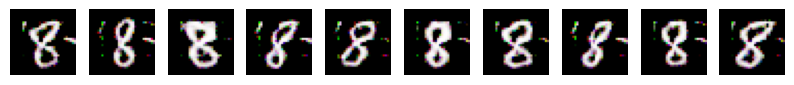

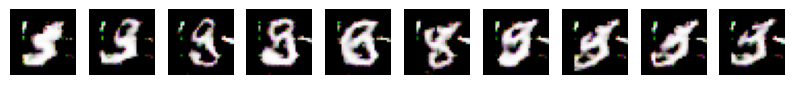

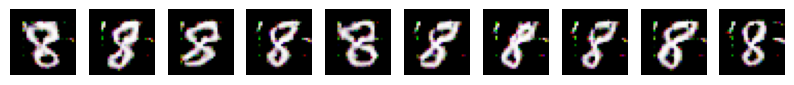

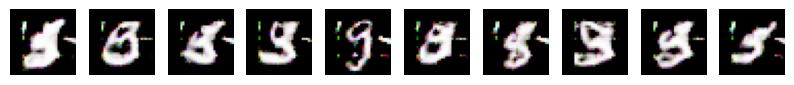

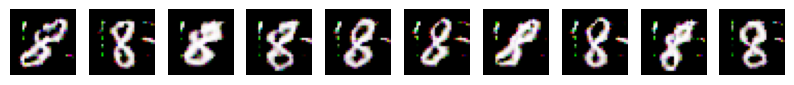

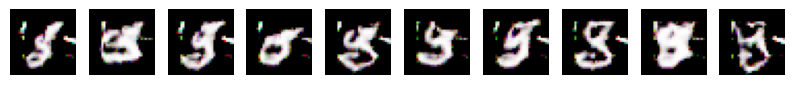

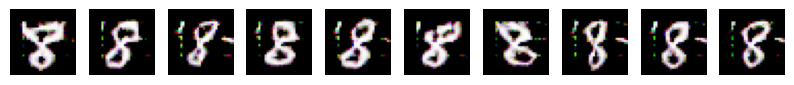

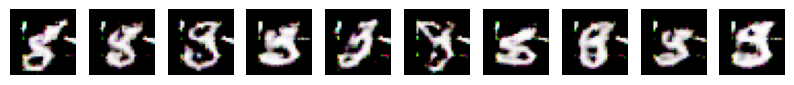

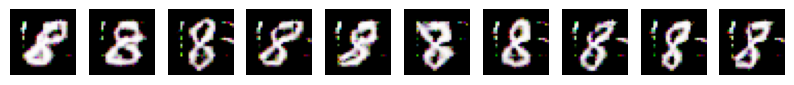

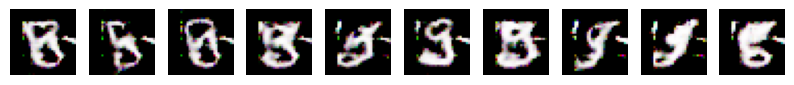

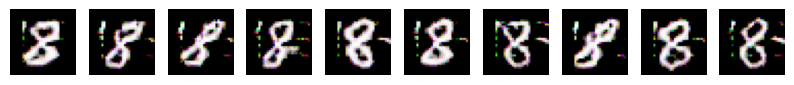

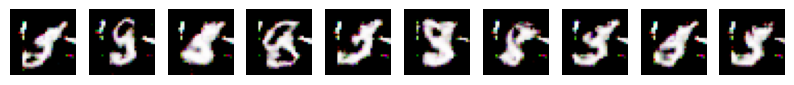

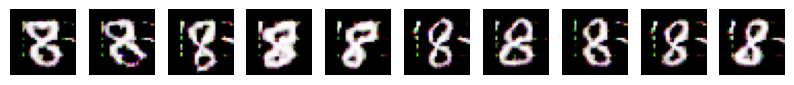

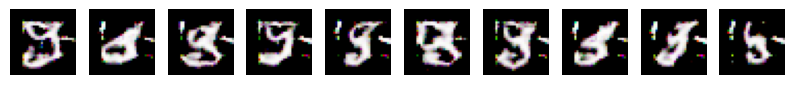

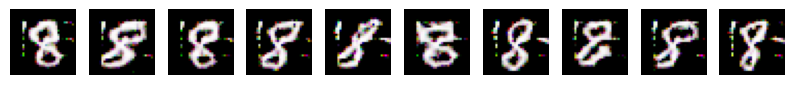

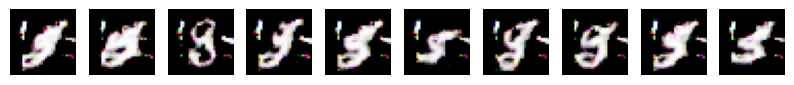

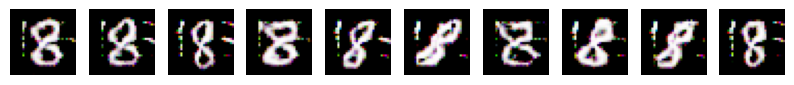

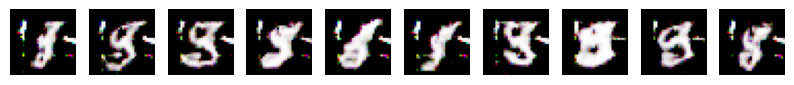

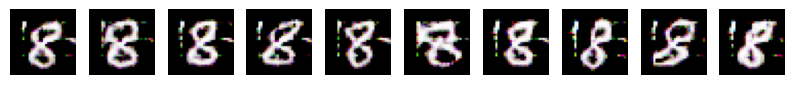

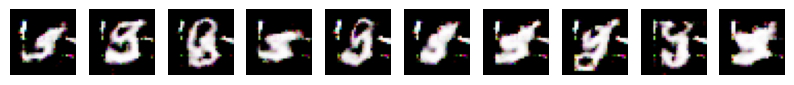

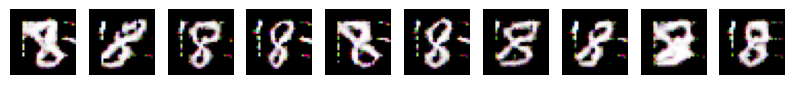

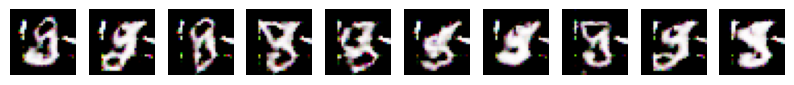

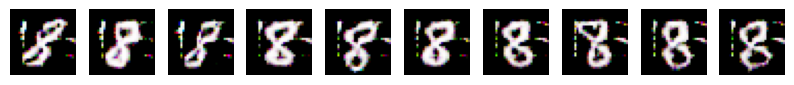

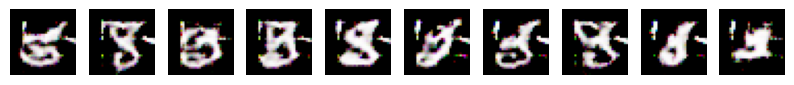

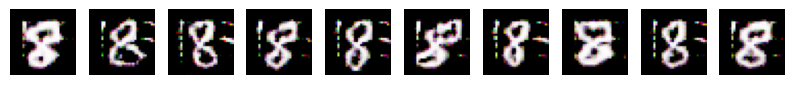

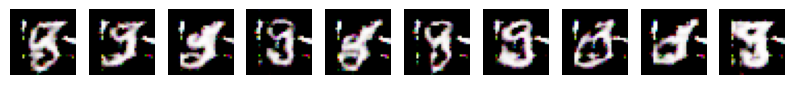

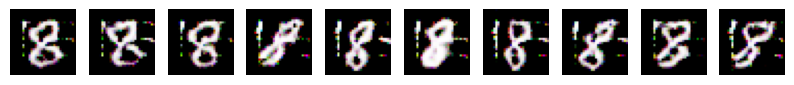

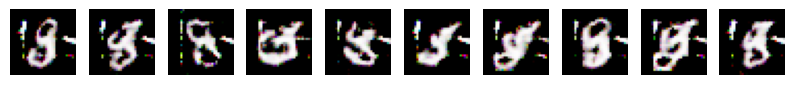

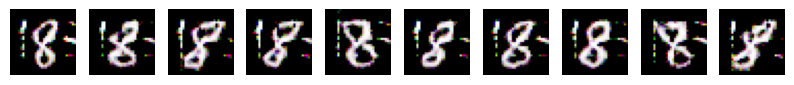

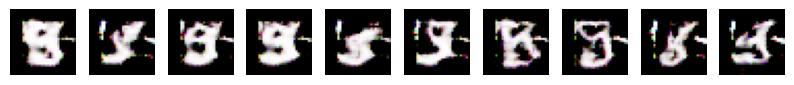

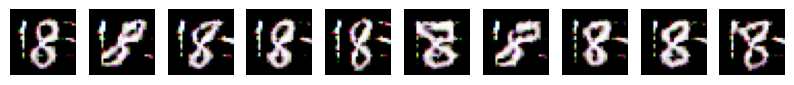

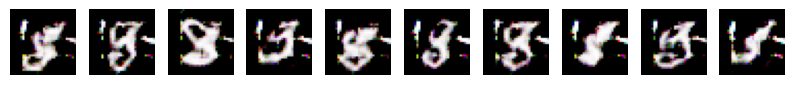

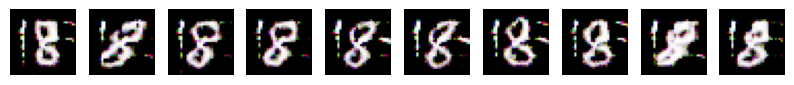

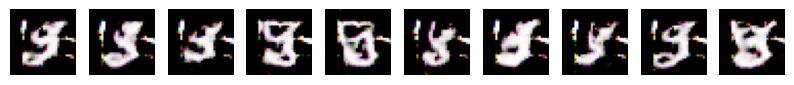

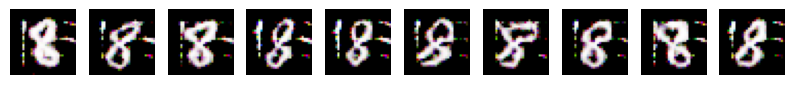

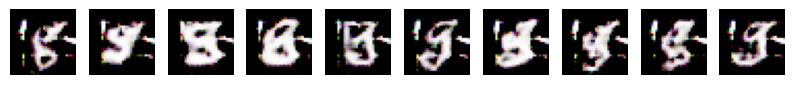

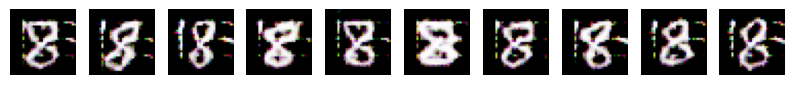

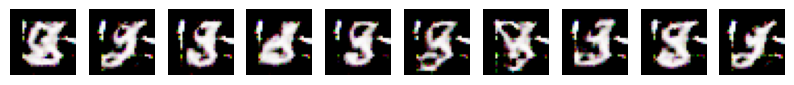

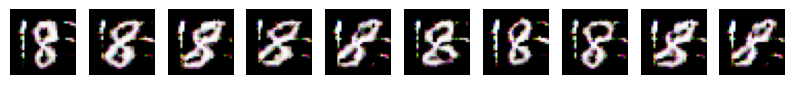

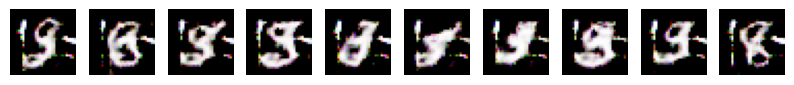

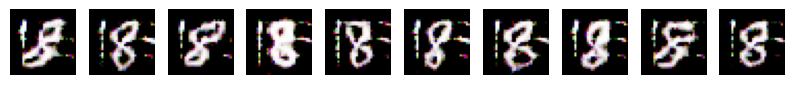

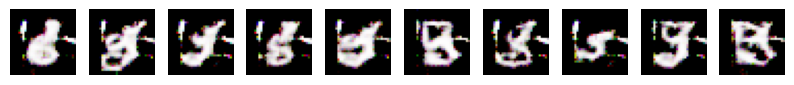

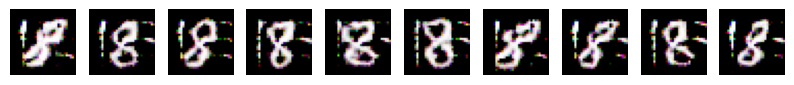

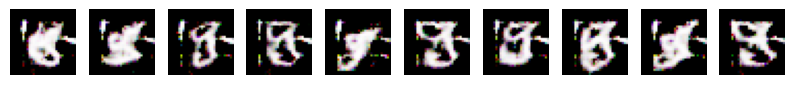

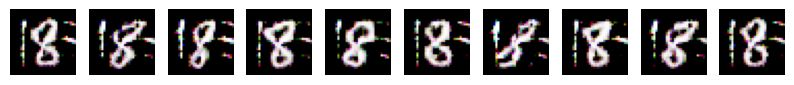

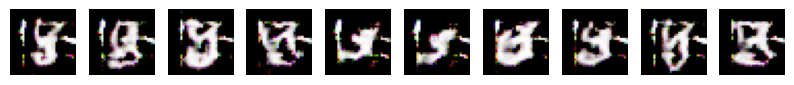

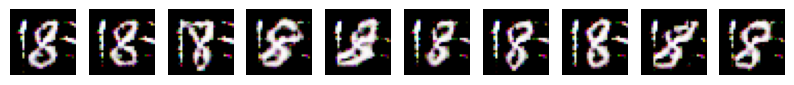

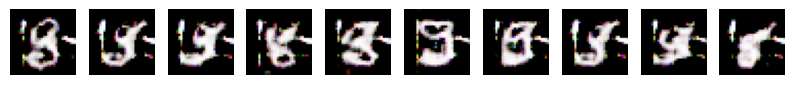

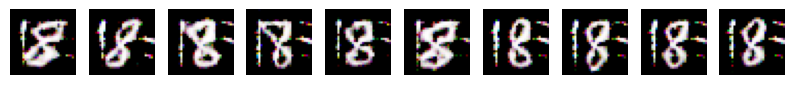

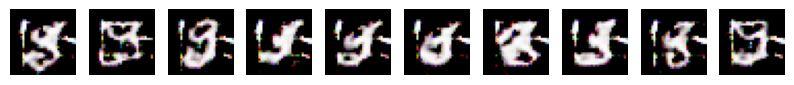

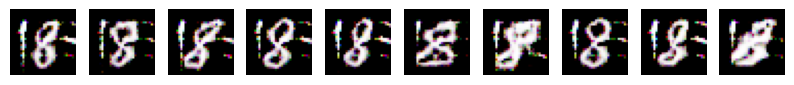

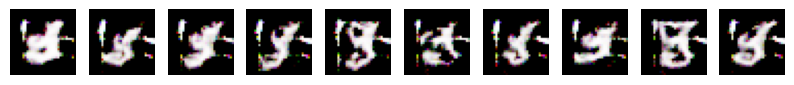

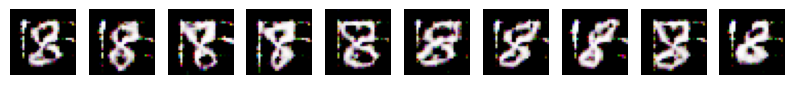

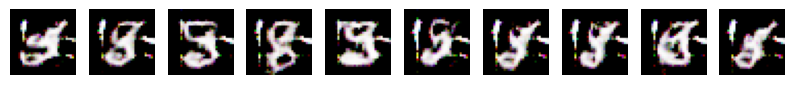

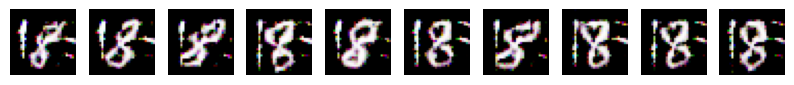

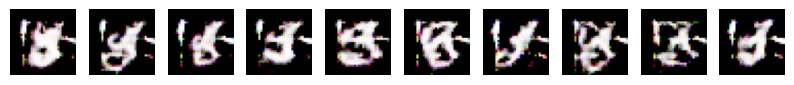

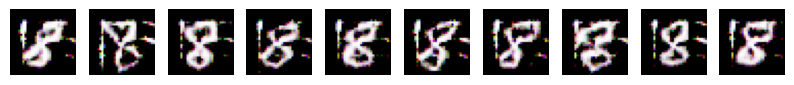

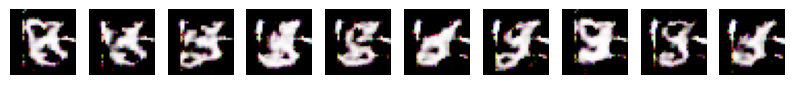

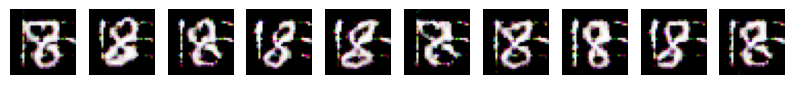

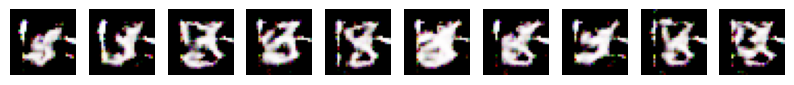

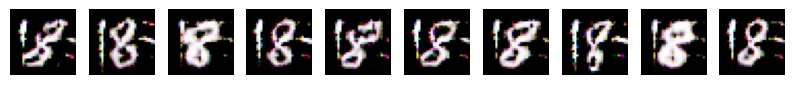

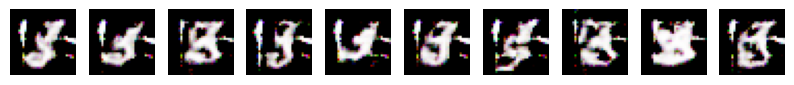

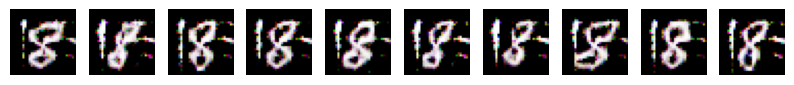

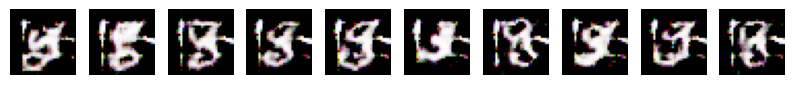

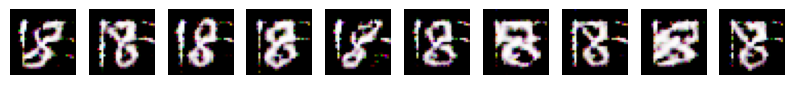

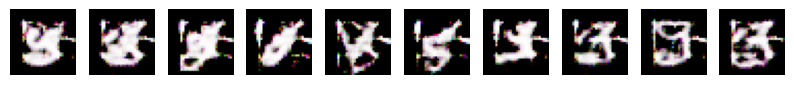

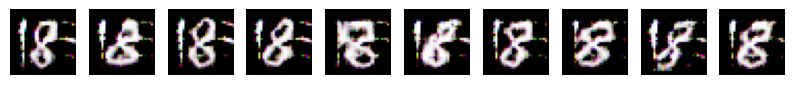

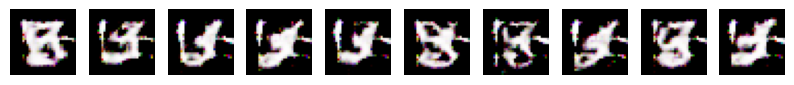

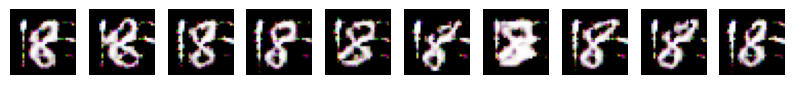

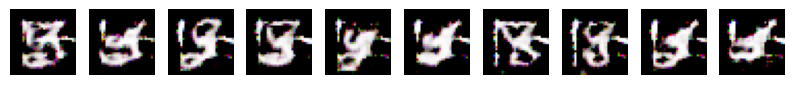

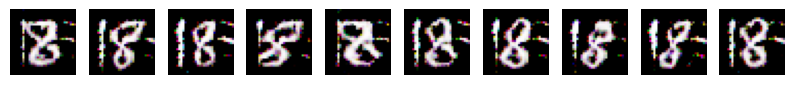

KeyboardInterrupt: 

In [ ]:
for epoch in range(num_epochs):
    positive_iter = iter(positive_loader)
    negative_iter = iter(negative_loader)
    num_batches = min(len(positive_loader), len(negative_loader))

    for i in range(num_batches):
        # Generate batch of latent vectors
        noise = torch.randn(batch_size, nz, 1, 1, device=device)

        # Generate class vector for label 5
        class_label = 5
        class_onehot = torch.zeros(batch_size, 10, 1, 1, device=device)
        class_onehot[:, class_label, :, :] = 1

        # Concatenate noise and class vector
        gen_input = torch.cat((noise, class_onehot), dim=1)

        # Generate images (anchors)
        fake_images = netG(gen_input)

        # Get positive images (labels != 5)
        try:
            positive_images, _ = next(positive_iter)
        except StopIteration:
            positive_iter = iter(positive_loader)
            positive_images, _ = next(positive_iter)

        # Get negative images (label 5)
        try:
            negative_images, _ = next(negative_iter)
        except StopIteration:
            negative_iter = iter(negative_loader)
            negative_images, _ = next(negative_iter)

        # Move images to device
        positive_images = positive_images.to(device)
        negative_images = negative_images.to(device)

        # Feature embeddings
        with torch.no_grad():
            positive_embeddings = feature_extractor(positive_images)
            negative_embeddings = feature_extractor(negative_images)

        # Compute anchor embeddings without torch.no_grad() to allow gradient flow to the generator
        anchor_embeddings = feature_extractor(fake_images)

        # Compute triplet loss
        triplet_loss = triplet_loss_fn(anchor_embeddings, positive_embeddings, negative_embeddings)

        # Apply Gradient Reversal Layer
        grl_output = grad_reverse(fake_images, lambda_grl)

        # Pass through feature extractor and classifier
        grl_embeddings = feature_extractor(grl_output)
        classifier_output = classifier(grl_embeddings)

        # Classification loss
        # Set target labels to class_label (which is 5)
        class_labels = torch.full((batch_size,), class_label, dtype=torch.long, device=device)
        classification_loss = classification_loss_fn(classifier_output, class_labels)

        loss = triplet_loss + alpha * classification_loss

        # Backpropagation and optimization
        optimizerG.zero_grad()
        loss.backward()
        optimizerG.step()
        test_label(netG, 5)
        test_label(netG, 8)
        netG.train()

        # if (i + 1) % 100 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{num_batches}], Loss: {loss.item():.4f}")

print("Training completed.")